# 📋 **Modélisation des Notes Clients**

## 🎯 Objectif :  
Prédire les notes clients à partir des avis textuels en utilisant des modèles de machine learning classiques.  
Cette phase comprend : la préparation des données, le traitement du texte, le rééquilibrage des classes, l’entraînement, l’évaluation et l’optimisation des modèles.

---

## 🗂️ **Plan du Notebook**

### I. 🗃️ Importation des Packages  
1. [Chargement et description des librairies essentielles](#1-importation-des-packages)
   
### II. 📥 Chargement et Exploration des Données  
2. [Chargement du dataset](#2-chargement-du-dataset)  
3. [Nettoyage rapide des données manquantes](#3-nettoyage-des-données-manquantes)  
4. [Analyse de la distribution des notes](#4-analyse-de-la-distribution-des-notes)

### III. 🧹 Préparation des Données  
5. [Séparation du jeu en train et test avec stratification](#5-separation-train-test)  
6. [Vectorisation TF-IDF avec suppression des stopwords](#6-vectorisation-tfidf)

### IV. 🔄 Rééquilibrage des Classes  
7. [Application de SMOTE sur le jeu d’entraînement](#7-application-de-smote)

### V. ⚙️ Définition d’une Fonction d’Évaluation des Modèles  
8. [Création d’une fonction d’entraînement et d’évaluation](#8-definition-fonction-evaluation)

### VI. 🚀 Entraînement et Évaluation des Modèles Classiques  
9. [Présentation des modèles sélectionnés](#9-presentation-des-modeles)  
10. [Entraînement, prédiction, et comparaison des performances](#10-entrainement-et-evaluation)

### VII. 📊 Analyse des résultats  
11. [Interprétation des résultats](#11-interpretation-resultats)

### VIII. 💡 Alternatives et améliorations possibles 
12. [Exploration des méthodes pour optimiser les modèles](#12-optimisation)

---


# I. 🗃️ Importation des Packages   

## 1. Chargement et description des librairies essentielles <a name="1-importation-des-packages"></a>

In [38]:
# Librairies pour la manipulation et visualisation des données
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Séparation train/test
from sklearn.model_selection import train_test_split

# Vectorisation TF-IDF du texte
from sklearn.feature_extraction.text import TfidfVectorizer

# Évaluation des modèles (rapport, matrice de confusion, précision)
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Rééquilibrage des classes avec SMOTE & ADASYN
from imblearn.over_sampling import SMOTE
from collections import Counter
from imblearn.over_sampling import SMOTE, ADASYN

# Modèles classiques de machine learning
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier

# Stopwords français pour le prétraitement textuel
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/laureneattia/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# II. 📥 Chargement et Exploration des Données 

## 2. Chargement du dataset <a name="2-chargement-du-dataset"></a>

In [51]:
# Chargement du fichier CSV contenant les avis nettoyés
df = pd.read_csv('reviews_trust_cleaned_imputed.csv')   

# Affichage d’un aperçu des premières lignes pour vérifier le contenu
display(df.head())

,Commentaire,star,commande_weekend,company_ShowRoom,company_VeePee,source_TrustPilot,source_TrustedShop,Commentaire_clean
0,"Bonjour , Ca doit faire 5 ans environ que je s...",1,0,1,0,1,0,bonjour ca doit ans environ membre showroopriv...
1,Vente lacoste article manquant photo prise sur...,1,0,1,0,1,0,vente lacoste article manquant photo prise art...
2,"Vente Lacoste Honteuse , article erroné , arti...",1,0,1,0,1,0,vente lacoste honteuse article erroné article ...
3,J'ai commandé des mules de la marque Moosefiel...,2,0,1,0,1,0,commandé mules marque moosefield très déçue pr...
4,Commande téléphone etat A+ . Livraison d un vi...,1,0,1,0,1,0,téléphone etat vieux téléphone pourri sans bat...


## 3. Nettoyage rapide des données manquantes <a name="3-nettoyage-des-données-manquantes"></a>

In [52]:
# Vérification des valeurs manquantes dans toutes les colonnes
missing_values = df.isna().sum()
print(missing_values)

# Nombre de valeurs manquantes dans la colonne 'Commentaire_clean' avant traitement
missing_before = df['Commentaire_clean'].isna().sum()
print(f"Valeurs manquantes avant traitement : {missing_before}")

# Remplacement des valeurs manquantes dans 'Commentaire_clean' par des chaînes vides
df['Commentaire_clean'] = df['Commentaire_clean'].fillna('')

# Vérification après traitement
missing_after = df['Commentaire_clean'].isna().sum()
print(f"Valeurs manquantes après traitement : {missing_after}")

Commentaire             0
star                    0
commande_weekend        0
company_ShowRoom        0
company_VeePee          0
source_TrustPilot       0
source_TrustedShop      0
Commentaire_clean     169
dtype: int64
Valeurs manquantes avant traitement : 169
Valeurs manquantes après traitement : 0


## 4. Analyse de la distribution des notes <a name="4-analyse-de-la-distribution-des-notes"></a>

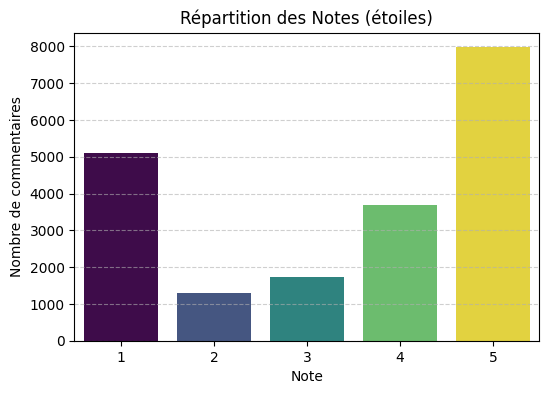

Nombre d'avis par note :
Note 1 : 5109 avis (25.8%)
Note 2 : 1309 avis (6.6%)
Note 3 : 1744 avis (8.8%)
Note 4 : 3700 avis (18.7%)
Note 5 : 7972 avis (40.2%)

Observations :
- Les notes 1 et 5 représentent la majorité des avis, tandis que les notes intermédiaires sont moins fréquentes.
- Cette répartition crée un déséquilibre des classes.

Nous devrons donc explorer des techniques adaptées pour gérer ce déséquilibre lors de la modélisation.


In [53]:
# Visualisation de la distribution des notes (étoiles) attribuées
plt.figure(figsize=(6,4))
sns.countplot(x='star', data=df, hue='star', palette='viridis', legend=False)
plt.title("Répartition des Notes (étoiles)")
plt.xlabel("Note")
plt.ylabel("Nombre de commentaires")
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()

# Résumé chiffré et analyse rapide
total_avis = len(df)
counts = df['star'].value_counts().sort_index()
percentages = counts / total_avis * 100

print("Nombre d'avis par note :")
for note, count in counts.items():
    print(f"Note {note} : {count} avis ({percentages[note]:.1f}%)")

print("\nObservations :")
print("- Les notes 1 et 5 représentent la majorité des avis, tandis que les notes intermédiaires sont moins fréquentes.")
print("- Cette répartition crée un déséquilibre des classes.")
print("\nNous devrons donc explorer des techniques adaptées pour gérer ce déséquilibre lors de la modélisation.")

# III. 🧹 Préparation des Données

## 5. Séparation du jeu en train et test avec stratification <a name="5-separation-train-test"></a>

In [54]:
# Séparation des features (texte) et de la cible (notes)
X = df['Commentaire_clean']
y = df['star']

# Division du dataset en jeu d'entraînement et de test
X_train_text, X_test_text, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

## 6. Vectorisation TF-IDF avec suppression des stopwords <a name="6-vectorisation-tfidf"></a>

In [55]:
# Chargement des stopwords français pour ignorer les mots fréquents peu informatifs
stopwords_fr = stopwords.words('french')

# Initialisation du vectoriseur TF-IDF 
vectorizer = TfidfVectorizer(
    ngram_range=(1, 2),  # Utilisation des unigrams et bigrams pour mieux capter le contexte
    max_features=10000, # Limitation à 10 000 tokens pour optimiser le temps de calcul
    stop_words=stopwords_fr #  Suppression des stopwords pour épurer le texte
)

# Entraînement du vectoriseur sur le texte d'entraînement et transformation en vecteurs numériques
X_train_vect = vectorizer.fit_transform(X_train_text)

# Transformation du texte de test avec le même vocabulaire (mêmes dimensions)
X_test_vect = vectorizer.transform(X_test_text)

# IV. 🔄 Rééquilibrage des Classes¶

## 7. Application de SMOTE sur le jeu d’entraînement <a name="7-application-de-smote"></a>

In [56]:
# Le jeu d'entraînement est déséquilibré : certaines notes (notamment 2, 3 et 4 étoiles)
# sont sous-représentées, ce qui peut nuire à la qualité des prédictions.

# SMOTE (Synthetic Minority Over-sampling Technique) permet de générer des exemples 
# synthétiques pour les classes minoritaires afin d’équilibrer le jeu d’entraînement.


# Application de SMOTE sur le jeu d'entraînement vectorisé
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train_vect, y_train)

# Vérification de la distribution des classes avant et après rééquilibrage
print("Distribution avant SMOTE :")
print(pd.Series(y_train).value_counts().sort_index())

print("\nDistribution après SMOTE :")
print(pd.Series(y_train_res).value_counts().sort_index())


Distribution avant SMOTE :
star
1    4087
2    1047
3    1395
4    2960
5    6378
Name: count, dtype: int64

Distribution après SMOTE :
star
1    6378
2    6378
3    6378
4    6378
5    6378
Name: count, dtype: int64


# V. ⚙️ Définition d’une Fonction d’Évaluation des Modèles  

## 8. Création d’une fonction d’entraînement et d’évaluation <a name="8-definition-fonction-evaluation"></a>

In [57]:
def test_model(clf, X_train, y_train, X_test, y_test):
    """
    Entraîne le modèle, prédit sur les données de test, affiche les métriques et la matrice de confusion,
    puis retourne un résumé des métriques principales.
    """
    clf.fit(X_train, y_train)   # Entraîne le modèle 'clf' sur les données d'entraînement
    y_pred = clf.predict(X_test) # Effectue les prédictions sur les données de test
    
    print(f"\n=== Résultats pour {clf.__class__.__name__} ===")    # Affiche le nom du modèle utilisé
    print(classification_report(y_test, y_pred))   # Affiche le rapport complet des métriques (précision, rappel, F1-score, etc.)
    
    # Affiche la matrice de confusion pour visualiser les erreurs de classification
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f"Matrice de confusion - {clf.__class__.__name__}")
    plt.xlabel("Classe prédite")
    plt.ylabel("Classe réelle")
    plt.show()
    
    # Calcule les métriques principales pour un résumé et une comparaison facile
    accuracy = accuracy_score(y_test, y_pred)   # Précision globale du modèle
    report = classification_report(y_test, y_pred, output_dict=True)  # Rapport des métriques sous forme de dictionnaire
    
    return {  # Retourne un résumé des métriques clés pour comparaison entre modèles
        'Model': clf.__class__.__name__,
        'Accuracy': accuracy,
        'Macro Precision': report['macro avg']['precision'],
        'Macro Recall': report['macro avg']['recall'],
        'Macro F1-score': report['macro avg']['f1-score']
    }


# VI. 🚀 Entraînement et Évaluation des Modèles Classiques  

## 9. Présentation des modèles sélectionnés <a name="9-presentation-des-modeles"></a>

| Modèle                    | Description                                                   
|--------------------------|---------------------------------------------------------------|
| LogisticRegression       | Modèle linéaire simple, rapide, performant avec TF-IDF.       | 
| MultinomialNB            | Naïve Bayes adapté aux données textuelles discrètes, robuste et rapide. | 
| LinearSVC                | SVM linéaire, efficace pour séparer les classes en NLP. |     
| RandomForestClassifier   | Ensemble d'arbres de décision, gère relations complexes.   |     
| GradientBoostingClassifier | Boosting d’arbres, performant mais plus lent.         |         
| KNeighborsClassifier     | Basé sur la distance, simple, baseline, moins efficace en haute dimension. | 



## 10. Entraînement, prédiction, et comparaison des performances <a name="10-entrainement-et-evaluation"></a>


=== Résultats pour LogisticRegression ===
              precision    recall  f1-score   support

           1       0.82      0.84      0.83      1022
           2       0.21      0.32      0.25       262
           3       0.25      0.35      0.29       349
           4       0.38      0.32      0.35       740
           5       0.80      0.71      0.75      1594

    accuracy                           0.61      3967
   macro avg       0.49      0.51      0.49      3967
weighted avg       0.64      0.61      0.62      3967



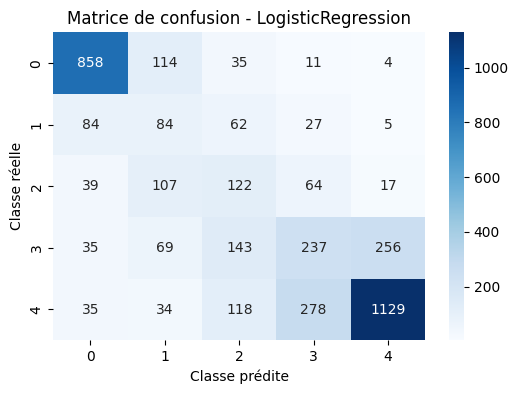


=== Résultats pour MultinomialNB ===
              precision    recall  f1-score   support

           1       0.74      0.83      0.78      1022
           2       0.19      0.31      0.23       262
           3       0.31      0.34      0.32       349
           4       0.40      0.27      0.32       740
           5       0.79      0.75      0.77      1594

    accuracy                           0.62      3967
   macro avg       0.49      0.50      0.49      3967
weighted avg       0.62      0.62      0.61      3967



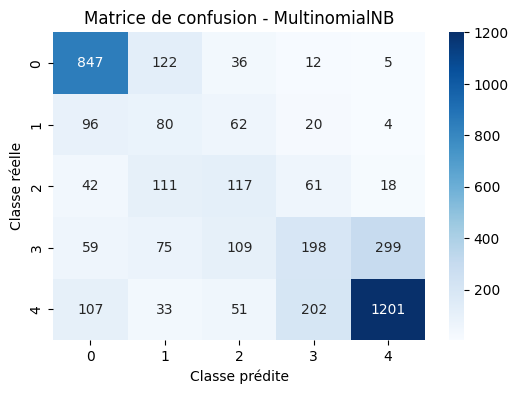


=== Résultats pour LinearSVC ===
              precision    recall  f1-score   support

           1       0.81      0.83      0.82      1022
           2       0.21      0.28      0.24       262
           3       0.24      0.31      0.27       349
           4       0.37      0.31      0.33       740
           5       0.78      0.73      0.76      1594

    accuracy                           0.61      3967
   macro avg       0.48      0.49      0.48      3967
weighted avg       0.63      0.61      0.62      3967



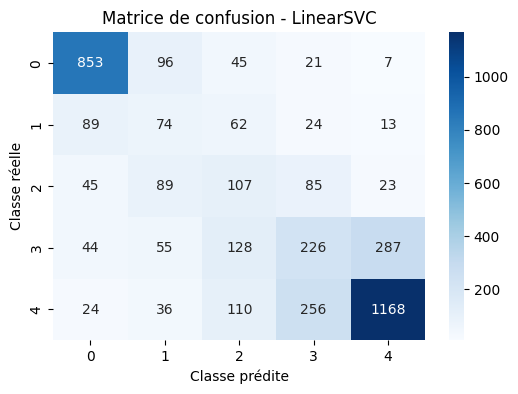


=== Résultats pour RandomForestClassifier ===
              precision    recall  f1-score   support

           1       0.77      0.90      0.83      1022
           2       0.25      0.10      0.14       262
           3       0.30      0.30      0.30       349
           4       0.38      0.34      0.36       740
           5       0.76      0.78      0.77      1594

    accuracy                           0.64      3967
   macro avg       0.49      0.48      0.48      3967
weighted avg       0.62      0.64      0.63      3967



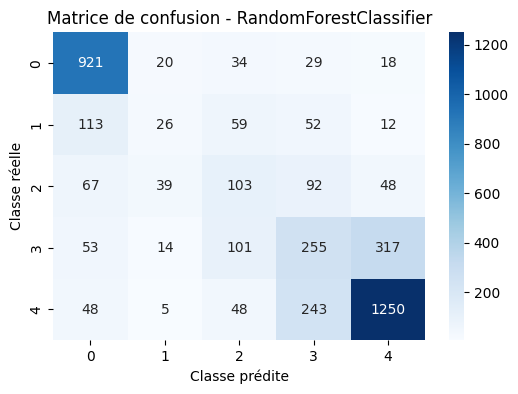


=== Résultats pour GradientBoostingClassifier ===
              precision    recall  f1-score   support

           1       0.83      0.78      0.80      1022
           2       0.19      0.20      0.20       262
           3       0.24      0.28      0.25       349
           4       0.30      0.40      0.35       740
           5       0.76      0.64      0.70      1594

    accuracy                           0.57      3967
   macro avg       0.46      0.46      0.46      3967
weighted avg       0.61      0.57      0.59      3967



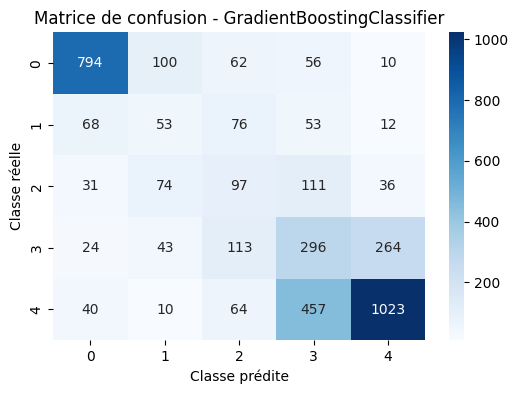


=== Résultats pour KNeighborsClassifier ===
              precision    recall  f1-score   support

           1       0.80      0.44      0.57      1022
           2       0.14      0.27      0.19       262
           3       0.15      0.51      0.23       349
           4       0.26      0.30      0.27       740
           5       0.81      0.46      0.58      1594

    accuracy                           0.41      3967
   macro avg       0.43      0.39      0.37      3967
weighted avg       0.60      0.41      0.47      3967



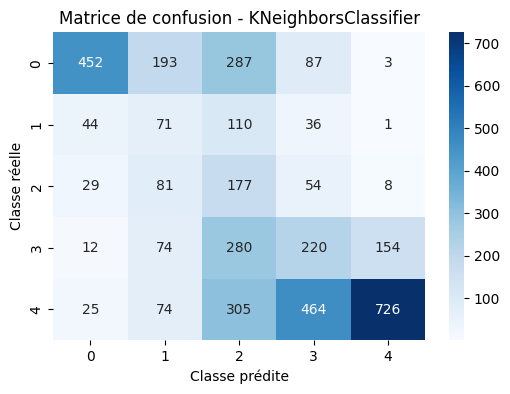


=== Comparatif des modèles ===
                         Model  Accuracy  Macro Precision  Macro Recall  \
0           LogisticRegression  0.607479         0.503803      0.517231   
1           LogisticRegression  0.607479         0.503803      0.517231   
2                MultinomialNB  0.613474         0.501217      0.509891   
3                MultinomialNB  0.613474         0.501217      0.509891   
4           LogisticRegression  0.612554         0.492135      0.507653   
5           LogisticRegression  0.612554         0.492135      0.507653   
6           LogisticRegression  0.612554         0.492135      0.507653   
7                MultinomialNB  0.615831         0.485208      0.498074   
8                MultinomialNB  0.615831         0.485208      0.498074   
9                MultinomialNB  0.615831         0.485208      0.498074   
10                   LinearSVC  0.612049         0.481134      0.492365   
11                   LinearSVC  0.612049         0.481134      0.492

In [58]:
models = [
    LogisticRegression(max_iter=1000, random_state=42),
    MultinomialNB(),
    LinearSVC(random_state=42, max_iter=10000),
    RandomForestClassifier(n_estimators=100, random_state=42),
    GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42),
    KNeighborsClassifier(n_neighbors=5)
]


# Pour chaque modèle, on entraîne, prédit et enregistre les métriques clés

#results = []
for model in models:
    res = test_model(model, X_train_res, y_train_res, X_test_vect, y_test)
    results.append(res)

# Création d'un tableau comparatif trié par F1-score macro (moyenne sur toutes les classes)
df_results = pd.DataFrame(results)
df_results = df_results.sort_values(by='Macro F1-score', ascending=False).reset_index(drop=True)

print("\n=== Comparatif des modèles ===")
print(df_results)


# VII. 📊 Analyse des résultats  

## 11. Interprétation des résultats <a name="11-interpretation-resultats"></a>


- **Meilleurs modèles :** LogisticRegression, MultinomialNB et RandomForest (~61% précision globale).  
- **Bonnes prédictions :** Classes extrêmes (1 & 5 étoiles) avec F1-score ~0.7-0.8.  
- **Difficultés :** Classes intermédiaires (2, 3, 4 étoiles) faibles (F1 ~0.25-0.35), dues au déséquilibre des classes. 
- **Rééquilibrage :** SMOTE améliore, mais ne suffit pas totalement.  
- **Améliorations possibles :** Utiliser des modèles à base d’**embeddings puissants** (ex : BERT) ou stratégies ciblées pour traiter les classes minoritaires.


# VIII. 💡 Alternatives et améliorations possibles 

## 12. Exploration des méthodes pour optimiser les modèles <a name="12-optimisation"></a>

- **GridSearchCV**  
  Permet d'optimiser les hyperparamètres des modèles (ex : `C` pour LogisticRegression, `n_estimators` pour RandomForest) afin d'améliorer leurs performances.

- **Avantages de GridSearchCV**  
  - Évite le choix arbitraire des paramètres  
  - Améliore la généralisation du modèle  
  - Peut aider à mieux gérer les classes difficiles

- **À combiner avec**  
  - SMOTE pour équilibrer les classes minoritaires  
  - Modèles basés sur des embeddings puissants (ex : BERT) pour un meilleur encodage du texte



In [ ]:
# ----------------- TESTS METHODE ADASYN --------------------#

In [59]:
# Import de la méthode ADASYN
from imblearn.over_sampling import ADASYN

# Application d'ADASYN sur le jeu d'entraînement vectorisé
adasyn = ADASYN(random_state=42, n_neighbors=3)
X_train_res_ada, y_train_res_ada = adasyn.fit_resample(X_train_vect, y_train)

# Vérification de la distribution des classes avant et après rééquilibrage
print("Distribution avant ADASYN :")
print(pd.Series(y_train).value_counts().sort_index())

print("\nDistribution après ADASYN :")
print(pd.Series(y_train_res_ada).value_counts().sort_index())

Distribution avant ADASYN :
star
1    4087
2    1047
3    1395
4    2960
5    6378
Name: count, dtype: int64

Distribution après ADASYN :
star
1    7363
2    6141
3    6485
4    7052
5    6378
Name: count, dtype: int64



=== Résultats pour LogisticRegression ===
              precision    recall  f1-score   support

           1       0.80      0.85      0.83      1022
           2       0.21      0.29      0.24       262
           3       0.26      0.35      0.30       349
           4       0.40      0.38      0.39       740
           5       0.81      0.69      0.74      1594

    accuracy                           0.62      3967
   macro avg       0.50      0.51      0.50      3967
weighted avg       0.64      0.62      0.63      3967



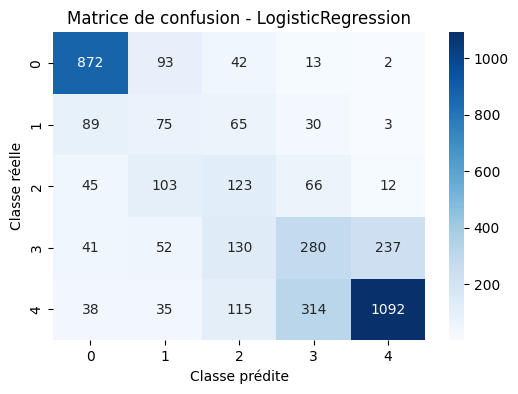


=== Résultats pour MultinomialNB ===
              precision    recall  f1-score   support

           1       0.72      0.85      0.78      1022
           2       0.21      0.24      0.22       262
           3       0.32      0.35      0.33       349
           4       0.39      0.32      0.35       740
           5       0.79      0.72      0.75      1594

    accuracy                           0.61      3967
   macro avg       0.48      0.50      0.49      3967
weighted avg       0.62      0.61      0.61      3967



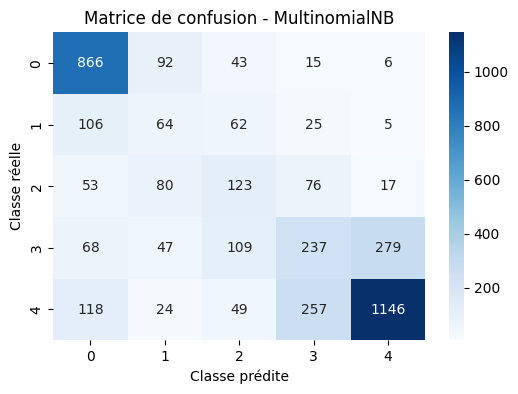


=== Résultats pour LinearSVC ===
              precision    recall  f1-score   support

           1       0.80      0.85      0.82      1022
           2       0.21      0.26      0.23       262
           3       0.25      0.32      0.28       349
           4       0.37      0.34      0.36       740
           5       0.79      0.71      0.75      1594

    accuracy                           0.61      3967
   macro avg       0.48      0.50      0.49      3967
weighted avg       0.63      0.61      0.62      3967



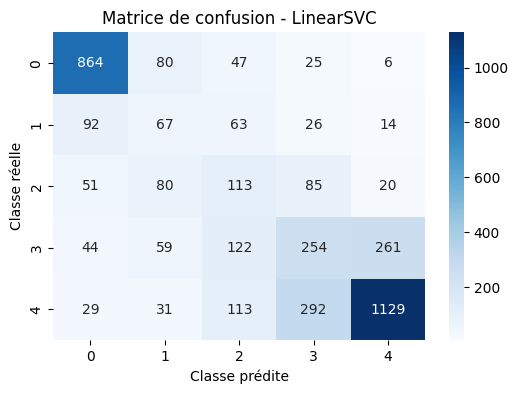


=== Résultats pour RandomForestClassifier ===
              precision    recall  f1-score   support

           1       0.75      0.91      0.82      1022
           2       0.25      0.10      0.14       262
           3       0.29      0.28      0.28       349
           4       0.36      0.34      0.35       740
           5       0.76      0.76      0.76      1594

    accuracy                           0.64      3967
   macro avg       0.48      0.48      0.47      3967
weighted avg       0.61      0.64      0.62      3967



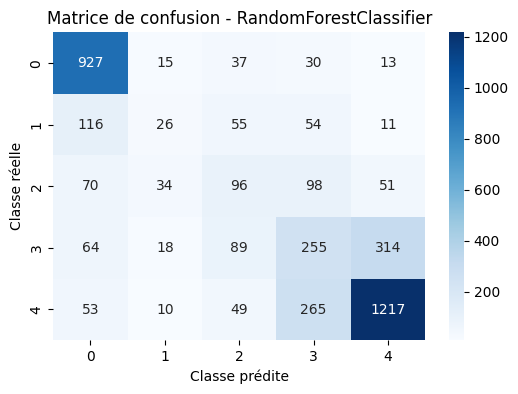


=== Résultats pour GradientBoostingClassifier ===
              precision    recall  f1-score   support

           1       0.82      0.79      0.81      1022
           2       0.19      0.16      0.17       262
           3       0.24      0.26      0.25       349
           4       0.31      0.47      0.37       740
           5       0.77      0.61      0.68      1594

    accuracy                           0.57      3967
   macro avg       0.47      0.46      0.46      3967
weighted avg       0.61      0.57      0.58      3967



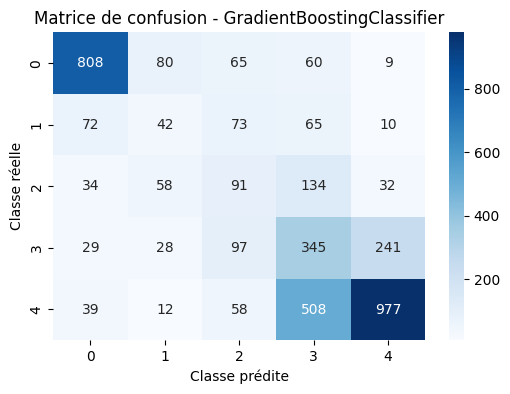


=== Résultats pour KNeighborsClassifier ===
              precision    recall  f1-score   support

           1       0.82      0.48      0.61      1022
           2       0.12      0.30      0.18       262
           3       0.16      0.46      0.24       349
           4       0.26      0.32      0.29       740
           5       0.81      0.41      0.55      1594

    accuracy                           0.41      3967
   macro avg       0.43      0.40      0.37      3967
weighted avg       0.61      0.41      0.46      3967



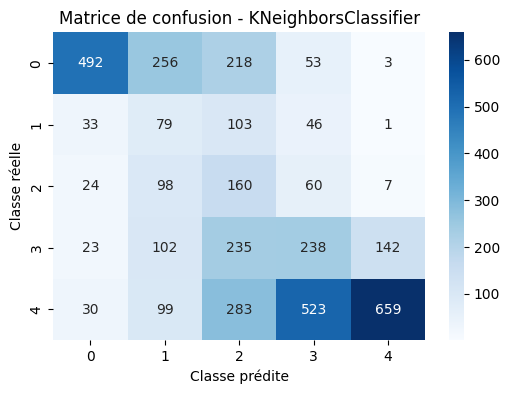


=== Comparatif des modèles avec ADASYN ===
                        Model  Accuracy  Macro Precision  Macro Recall  \
0          LogisticRegression  0.615579         0.496343      0.511074   
1               MultinomialNB  0.614066         0.483894      0.496657   
2                   LinearSVC  0.611797         0.484005      0.495287   
3      RandomForestClassifier  0.635493         0.484319      0.477887   
4  GradientBoostingClassifier  0.570456         0.466170      0.458159   
5        KNeighborsClassifier  0.410386         0.434463      0.395287   

   Macro F1-score  
0        0.499827  
1        0.487723  
2        0.487499  
3        0.472896  
4        0.456805  
5        0.370837  


In [60]:
# Évaluation des modèles avec les données rééquilibrées par ADASYN
results_adasyn = []
for model in models:
    res = test_model(model, X_train_res_ada, y_train_res_ada, X_test_vect, y_test)
    results_adasyn.append(res)

# Comparaison des résultats
df_results_adasyn = pd.DataFrame(results_adasyn)
df_results_adasyn = df_results_adasyn.sort_values(by='Macro F1-score', ascending=False).reset_index(drop=True)

print("\n=== Comparatif des modèles avec ADASYN ===")
print(df_results_adasyn)

In [61]:
# Ajout d'une colonne pour indiquer la méthode de rééquilibrage
df_results['Rééquilibrage'] = 'SMOTE'
df_results_adasyn['Rééquilibrage'] = 'ADASYN'

# Fusion des deux tableaux
df_comparatif = pd.concat([df_results, df_results_adasyn], ignore_index=True)

# Affichage du tableau comparatif global
print("\n=== Comparaison globale SMOTE vs ADASYN ===")
print(df_comparatif.sort_values(by=['Model', 'Rééquilibrage']))



=== Comparaison globale SMOTE vs ADASYN ===
                         Model  Accuracy  Macro Precision  Macro Recall  \
34  GradientBoostingClassifier  0.570456         0.466170      0.458159   
13  GradientBoostingClassifier  0.568370         0.486817      0.480758   
14  GradientBoostingClassifier  0.568370         0.486817      0.480758   
22  GradientBoostingClassifier  0.570456         0.463841      0.459783   
23  GradientBoostingClassifier  0.570456         0.463841      0.459783   
24  GradientBoostingClassifier  0.570456         0.463841      0.459783   
35        KNeighborsClassifier  0.410386         0.434463      0.395287   
25        KNeighborsClassifier  0.414923         0.434085      0.394636   
26        KNeighborsClassifier  0.414923         0.434085      0.394636   
27        KNeighborsClassifier  0.414923         0.434085      0.394636   
28        KNeighborsClassifier  0.346846         0.422962      0.351311   
29        KNeighborsClassifier  0.346846         0.4229

In [ ]:
#➡️ ADASYN est légèrement meilleur pour les modèles linéaires (LogisticRegression, LinearSVC)
#➡️ SMOTE est meilleur sur les modèles basés sur des arbres et Naïve Bayes